# Error mesage

This code shows that an error occures when we try to run the function  `fcm.FCM_Plotter`

In [9]:
import os
import re
import glob
import random
import numpy as np
import scipy
import scipy.io as sio
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.patches import Patch, Circle
from matplotlib.lines import Line2D
from PIL import Image
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual  # package for interactive widgets 
import braingeneers                                                   # Braingeneers code
from braingeneers.analysis.analysis import SpikeData, read_phy_files
import braingeneers.data.datasets_electrophysiology as ephys
from IPython.display import HTML, display, Javascript, clear_output
from matplotlib.patches import FancyArrow

In [2]:
import fcm_fix

In [3]:
file = '/home/jovyan/work/Experiment/data/ephys/2023-04-02-hc328_rec/derived/kilosort2/2023_04_02_hc328_5_curated.zip'

In [4]:
sd = read_phy_files(file)

/tmp/ipykernel_22548/1125946852.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  sd = read_phy_files(file)


In [5]:
def FCM_Plotter(dataset_path, start, stop, name, latency_thresh=0.2, latencies_ms_thresh=100, line_threshold=0.5, saved='yes'):
    sd = read_phy_files(dataset_path)
    sd_start = sd.subtime(start*1000, stop*1000)

    not_empties = []
    empties = []
    arrays = sd_start.train
    

    for i, arr in enumerate(arrays):
        if len(arr) > 0:
            not_empties.append(i)
        if len(arr) == 0:
            empties.append(i)

    sub_start = sd_start.subset(not_empties)

    def latencies_mean(lat_list):
        nested_list = lat_list
        for i in range(len(nested_list)):
            sublist = nested_list[i]
            length = len(sublist)
            if length == 0:
                sublist_mean = 0
            else:
                sublist_mean = sum(sublist) / len(sublist)
                sublist_mean = round(sublist_mean, 3)  # Round to 3d.p.
            nested_list[i] = sublist_mean
        return nested_list

    def calculate_mean_latencies(sd, latencies_ms_thresh):
        num_neurons = sd.N
        latencies_array = [None] * num_neurons

        for curr_neuron in range(num_neurons):
            latencies = latencies_mean(sd.latencies_to_index(curr_neuron, window_ms=latencies_ms_thresh))
            latencies_array[curr_neuron] = latencies

        return latencies_array

    start_latencies = calculate_mean_latencies(sub_start, latencies_ms_thresh)

    def compute_in_out_degree(latencies_array):
        num_neurons = len(latencies_array)
        in_out_deg = [(0, 0) for _ in range(num_neurons)]

        for curr_neuron in range(num_neurons):
            in_deg = 0
            out_deg = 0
            curr_neural_latencies = latencies_array[curr_neuron]

            for i in range(len(curr_neural_latencies)):
                if curr_neural_latencies[i] > 0:
                    out_deg += 1
                if curr_neural_latencies[i] < 0:
                    in_deg += 1

            in_out_deg[curr_neuron] = (in_deg, out_deg)

        return in_out_deg

    start_in_out_deg = compute_in_out_degree(start_latencies)

    def label_nodes(in_out_deg, latency_thresh=0.2):
        node_info = ['grey'] * len(in_out_deg)

        for i in range(len(in_out_deg)):
            test1 = (in_out_deg[i][1] - in_out_deg[i][0]) / (in_out_deg[i][1] + in_out_deg[i][0])
            test2 = (in_out_deg[i][0] - in_out_deg[i][1]) / (in_out_deg[i][1] + in_out_deg[i][0])

            if test1 > latency_thresh:
                node_info[i] = 'red'
            if test2 > latency_thresh:
                node_info[i] = 'blue'

        return node_info

    colors = label_nodes(start_in_out_deg, latency_thresh)

    def closest_value(number):
        closest = 5
        if abs(number - 20) < abs(number - closest):
            closest = 20
        if abs(number - 50) < abs(number - closest):
            closest = 50
        return closest

    sub_start.neuron_data2 = sd_start.neuron_data
    neur_data = sub_start.neuron_data2[0]
    for key in empties:
        del neur_data[key]
    sub_start.neuron_data2[0] = neur_data

    def sttc_neuron_plotter(inp_sd, upd_node_info, line_threshold):
        neuron_x = []
        neuron_y = []
        neuron_amp = []

        for neuron in inp_sd.neuron_data2[0].values():
            neuron_x.append(neuron['position'][0])
            neuron_y.append(neuron['position'][1])
            neuron_amp.append(np.mean(neuron['amplitudes']))

        neuron_amp = [closest_value(num) for num in neuron_amp]

        plt.figure(figsize=(8, 6))
        savedFCMplot = plt.scatter(neuron_x, neuron_y, s=neuron_amp, c=upd_node_info)

        threshold = line_threshold
        sttc = inp_sd.spike_time_tilings()

        for i in range(sttc.shape[0]):
            for j in range(sttc.shape[1]):
                if i <= j:
                    continue
                if sttc[i, j] < threshold:
                    continue
                if i in empties:
                    continue
                if j in empties:
                    continue
                ix, iy = inp_sd.neuron_data2[0][i]['position']
                jx, jy = inp_sd.neuron_data2[0][j]['position']
                linewidth = 1.5 + 2 * (sttc[i, j] - threshold)
                opacity = 0.2 + 0.8 * (sttc[i, j] - threshold)
                plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)

        plt.xlabel('um')
        plt.ylabel('um')
        plt.title(f"{name}")  # Adding the title

        # Set fixed limits for x and y axes
        plt.xlim(600, 2000)
        plt.ylim(0, 2200)

        node_degree_legend_elements = [
            plt.scatter([], [], s=5, marker='o', edgecolor='black', facecolor='none', label='5'),
            plt.scatter([], [], s=20, marker='o', edgecolor='black', facecolor='none', label='20'),
            plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='none', label='50')
        ]

        node_type_legend_elements = [
            plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
            plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
            plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
        ]

        node_degree_legend = plt.legend(handles=node_degree_legend_elements, title='Node Degree', loc='lower right')
        plt.gca().add_artist(node_degree_legend)

        correlation_legend_elements = [
            plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
            plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
            plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
        ]

        correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
        plt.gca().add_artist(correlation_legend)

        node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')
        if saved.lower() == "yes":
            # save plot to folder
            savepath = "/home/jovyan/work/Human_Hippocampus/saved_plots/fcm/" + f"{name}_{start}_to_{stop}sec.png"
            plt.savefig(savepath)
            plt.close()
        elif saved.lower() == "return":
            # saves plot to variable
            return savedFCMplot
        else:
            # plots locally 
            return
        
    sttc_neuron_plotter(sub_start, colors,line_threshold)

/tmp/ipykernel_22548/3918715292.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  sd = read_phy_files(dataset_path)
/tmp/ipykernel_22548/3918715292.py:88: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sub_start.neuron_data2 = sd_start.neuron_data


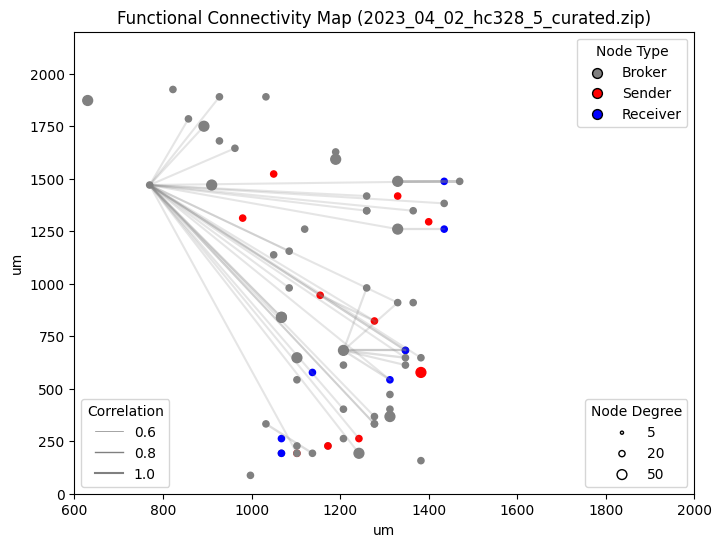

In [6]:
FCM_Plotter(file, 0, 70, "Functional Connectivity Map (2023_04_02_hc328_5_curated.zip)", 0.2, 50, 0.5, "no")

In [16]:
def FCM_Plotter(dataset_path, start, stop, name, latency_thresh=0.2, latencies_ms_thresh=100, line_threshold=0.5, saved='yes'):
    sd = read_phy_files(dataset_path)
    sd_start = sd.subtime(start*1000, stop*1000)

    not_empties = []
    empties = []
    arrays = sd_start.train
    

    for i, arr in enumerate(arrays):
        if len(arr) > 0:
            not_empties.append(i)
        if len(arr) == 0:
            empties.append(i)

    sub_start = sd_start.subset(not_empties)

    def latencies_mean(lat_list):
        nested_list = lat_list
        for i in range(len(nested_list)):
            sublist = nested_list[i]
            length = len(sublist)
            if length == 0:
                sublist_mean = 0
            else:
                sublist_mean = sum(sublist) / len(sublist)
                sublist_mean = round(sublist_mean, 3)  # Round to 3d.p.
            nested_list[i] = sublist_mean
        return nested_list

    def calculate_mean_latencies(sd, latencies_ms_thresh):
        num_neurons = sd.N
        latencies_array = [None] * num_neurons

        for curr_neuron in range(num_neurons):
            latencies = latencies_mean(sd.latencies_to_index(curr_neuron, window_ms=latencies_ms_thresh))
            latencies_array[curr_neuron] = latencies

        return latencies_array

    start_latencies = calculate_mean_latencies(sub_start, latencies_ms_thresh)

    def compute_in_out_degree(latencies_array):
        num_neurons = len(latencies_array)
        in_out_deg = [(0, 0) for _ in range(num_neurons)]

        for curr_neuron in range(num_neurons):
            in_deg = 0
            out_deg = 0
            curr_neural_latencies = latencies_array[curr_neuron]

            for i in range(len(curr_neural_latencies)):
                if curr_neural_latencies[i] > 0:
                    out_deg += 1
                if curr_neural_latencies[i] < 0:
                    in_deg += 1

            in_out_deg[curr_neuron] = (in_deg, out_deg)

        return in_out_deg

    start_in_out_deg = compute_in_out_degree(start_latencies)

    def label_nodes(in_out_deg, latency_thresh=0.2):
        node_info = ['grey'] * len(in_out_deg)

        for i in range(len(in_out_deg)):
            test1 = (in_out_deg[i][1] - in_out_deg[i][0]) / (in_out_deg[i][1] + in_out_deg[i][0])
            test2 = (in_out_deg[i][0] - in_out_deg[i][1]) / (in_out_deg[i][1] + in_out_deg[i][0])

            if test1 > latency_thresh:
                node_info[i] = 'red'
            if test2 > latency_thresh:
                node_info[i] = 'blue'

        return node_info

    colors = label_nodes(start_in_out_deg, latency_thresh)

    def closest_value(number):
        closest = 5
        if abs(number - 20) < abs(number - closest):
            closest = 20
        if abs(number - 50) < abs(number - closest):
            closest = 50
        return closest

    sub_start.neuron_data2 = sd_start.neuron_data
    neur_data = sub_start.neuron_data2[0]
    for key in empties:
        del neur_data[key]
    sub_start.neuron_data2[0] = neur_data

    def sttc_neuron_plotter(inp_sd, upd_node_info, thresh):
        neuron_x = []
        neuron_y = []
        neuron_amp = []

        for neuron in inp_sd.neuron_data2[0].values():
            neuron_x.append(neuron['position'][0])
            neuron_y.append(neuron['position'][1])
            neuron_amp.append(np.mean(neuron['amplitudes']))

        neuron_amp = [closest_value(num) for num in neuron_amp]

        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(neuron_x, neuron_y, s=neuron_amp, c=upd_node_info)

        threshold = thresh
        sttc = inp_sd.spike_time_tilings()

        for i in range(sttc.shape[0]):
            for j in range(sttc.shape[1]):
                if i <= j:
                    continue
                if sttc[i, j] < threshold:
                    continue
                if i == 6 and j == 21:
                    ix, iy = inp_sd.neuron_data2[0][i]['position']
                    jx, jy = inp_sd.neuron_data2[0][j]['position']
                    linewidth = 2.0  # Set a thicker linewidth
#                     arrow = FancyArrow(jx, jy, ix - jx, iy - jy, length_includes_head=True, head_width=35,
#                                        linewidth=linewidth, color='black', alpha=0.7, edgecolor='black', facecolor='black')
#                     ax.add_patch(arrow)
#                     linewidth = 2.0  # Set a thicker linewidth
                    arrow = FancyArrow(jx, jy, ix - jx, iy - jy, length_includes_head=True, head_width=35,
                                       linewidth=linewidth, color='black', alpha=0.7, edgecolor='black', facecolor='black')
                    plt.gca().add_patch(arrow)
                elif i in empties:
                    continue
                elif j in empties:
                    continue
                else:
                    ix, iy = inp_sd.neuron_data2[0][i]['position']
                    jx, jy = inp_sd.neuron_data2[0][j]['position']
                    linewidth = 1.5 + 2 * (sttc[i, j] - threshold)
                    opacity = 0.2 + 0.8 * (sttc[i, j] - threshold)
                    ax.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)

        ax.set_xlabel('um')
        ax.set_ylabel('um')
        ax.set_title("Directionality plot")  # Adding the title

        # Set fixed limits for x and y axes
        ax.set_xlim(600, 2000)
        ax.set_ylim(0, 2200)

        node_degree_legend_elements = [
            ax.scatter([], [], s=5, marker='o', edgecolor='black', facecolor='none', label='5'),
            ax.scatter([], [], s=20, marker='o', edgecolor='black', facecolor='none', label='20'),
            ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='none', label='50')
        ]

        node_type_legend_elements = [
            ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
            ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
            ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
        ]

        node_degree_legend = ax.legend(handles=node_degree_legend_elements, title='Node Degree', loc='lower right')
        ax.add_artist(node_degree_legend)

        correlation_legend_elements = [
            plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
            plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
            plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
        ]

        correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
        ax.add_artist(correlation_legend)

        node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')

        plt.show()

    # Call the function with the modified code
    sttc_neuron_plotter(sub_start, colors, line_threshold)

/tmp/ipykernel_22548/2432361102.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  sd = read_phy_files(dataset_path)
/tmp/ipykernel_22548/2432361102.py:88: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sub_start.neuron_data2 = sd_start.neuron_data


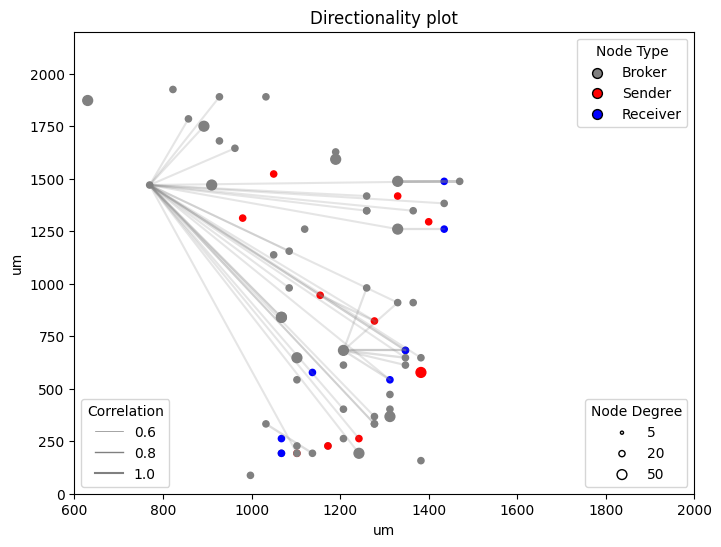

In [17]:
FCM_Plotter(file, 0, 70, "Functional Connectivity Map (2023_04_02_hc328_5_curated.zip)", 0.2, 50, 0.5, "no")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import FancyArrow

def sttc_neuron_plotter_3(inp_sd, thresh):
    neuron_x = []
    neuron_y = []
    neuron_amp = []

    for neuron in inp_sd.neuron_data[0].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
        neuron_amp.append(np.mean(neuron['amplitudes']))

    neuron_amp = [closest_value(num) for num in neuron_amp]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(neuron_x, neuron_y, s=neuron_amp)

    threshold = thresh
    sttc = inp_sd.spike_time_tilings()

    for i in range(sttc.shape[0]):
        for j in range(sttc.shape[1]):
            if i <= j:
                continue
            if sttc[i, j] < threshold:
                continue
#             if i in [7, 10, 16, 43, 48, 66, 67]:
#                 continue
#             if j in [7, 10, 16, 43, 48, 66, 67]:
                continue
            ix, iy = inp_sd.neuron_data[0][i]['position']
            jx, jy = inp_sd.neuron_data[0][j]['position']
            linewidth = 1.5 + 2 * (sttc[i, j] - threshold)
            opacity = 0.2 + 0.8 * (sttc[i, j] - threshold)
            if i == 6 and j == 21:
                linewidth = 2.0  # Set a thicker linewidth
                arrow = FancyArrow(jx, jy, ix - jx, iy - jy, length_includes_head=True, head_width=35,
                                   linewidth=linewidth, color='black', alpha=0.7, edgecolor='black', facecolor='black')
                plt.gca().add_patch(arrow)

            else:
                ax.plot([ix, jx], [iy, jy], linewidth=linewidth, color='grey', alpha=opacity)

    ax.set_xlabel('um')
    ax.set_ylabel('um')
    ax.set_title("Directionality plot")  # Adding the title

    node_degree_legend_elements = [
        ax.scatter([], [], s=5, marker='o', edgecolor='black', facecolor='none', label='5'),
        ax.scatter([], [], s=20, marker='o', edgecolor='black', facecolor='none', label='20'),
        ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='none', label='50')
    ]

    node_type_legend_elements = [
        ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
        ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
        ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
    ]

    node_degree_legend = ax.legend(handles=node_degree_legend_elements, title='Node Degree', loc='lower right')
    ax.add_artist(node_degree_legend)

    correlation_legend_elements = [
        plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
        plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
        plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
    ]

    correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
    ax.add_artist(correlation_legend)

    node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')

    plt.show()